## Electricity Production Forecasting using SARIMAX

In [49]:
## Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [50]:
electric = pd.read_csv('Electric_Production.csv')

In [51]:
electric.shape

(397, 2)

In [52]:
electric.head(5)

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [53]:
electric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


### Converting the datatype of DATE col from object to datetime

In [54]:
electric['DATE'] = pd.to_datetime(electric['DATE'])
electric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        397 non-null    datetime64[ns]
 1   IPG2211A2N  397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


In [55]:
### Resetting Index
electric.set_index('DATE', inplace= True)

In [56]:
electric.head(5)

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


Text(0.5, 1.0, 'Plotting Electric Production')

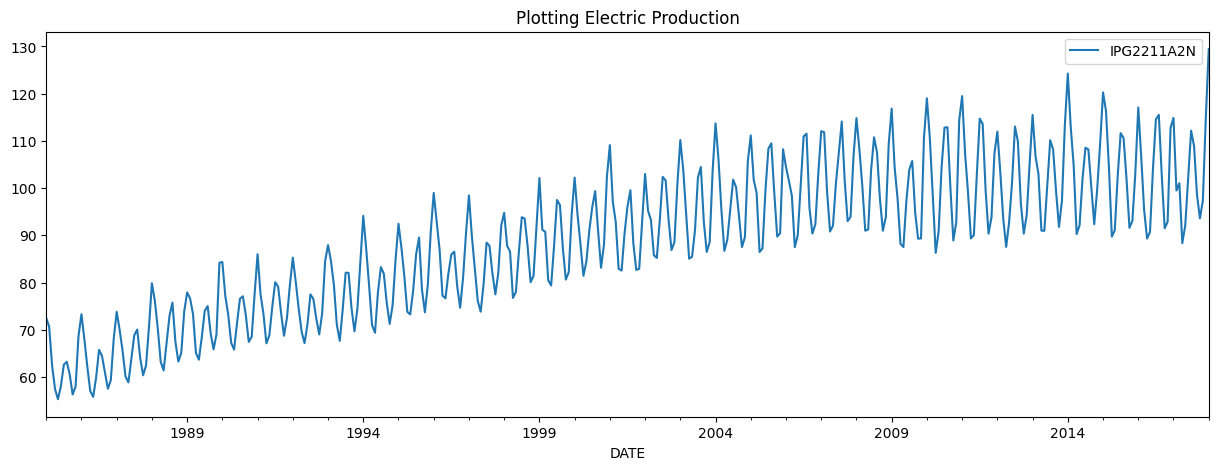

In [57]:
### Data Visualization
electric.plot(figsize = (15,5))
plt.title("Plotting Electric Production")

In [58]:
## Augmented Dicky Fuller Test to Check the Seasonality
def adf_test(data):
    result = adfuller(data)
    print(f'Ada Statistics : {result[0]}')
    print(f'P-Value : {result[1]}')
    if result[1] <= 0.05:
        print('Reject the null Hypothesis - Data is Stationary')
    else:
        print('Not Reject the null Hypothesis - Data is Not Stationary')


In [59]:
adf_test(electric['IPG2211A2N'])

Ada Statistics : -2.25699035004725
P-Value : 0.18621469116586592
Not Reject the null Hypothesis - Data is Not Stationary


## Differencing

In [60]:
electric['Order_12'] = electric['IPG2211A2N'] - electric['IPG2211A2N'].shift(12)

In [61]:
electric.isna().sum()

IPG2211A2N     0
Order_12      12
dtype: int64

In [62]:
adf_test(electric['Order_12'].dropna())

Ada Statistics : -5.673482023381753
P-Value : 8.812644938089282e-07
Reject the null Hypothesis - Data is Stationary


### Plotting Stationary Data

Text(0.5, 1.0, 'Plotting the Stationary Data')

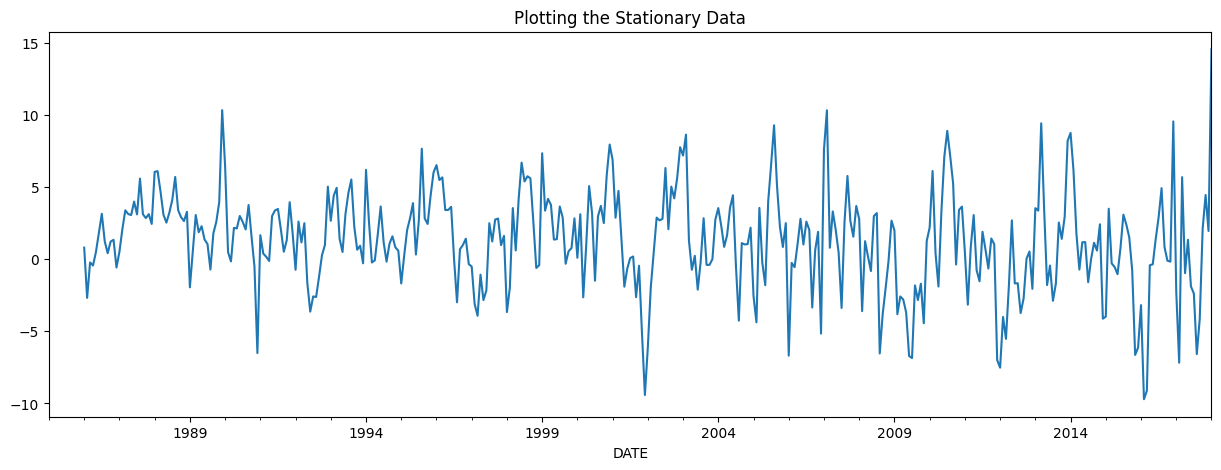

In [64]:
### Data Visualization
electric['Order_12'].plot(figsize = (15,5))
plt.title("Plotting the Stationary Data")

#### Obtaining the Values p, d, q

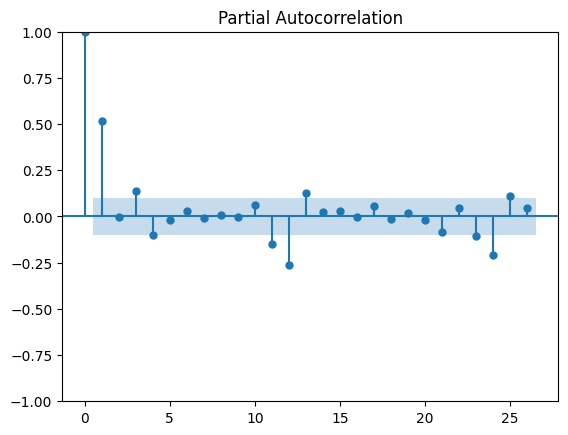

In [65]:
# Partial Auto Correlation Analysis
pacf= plot_pacf(electric['Order_12'].dropna())

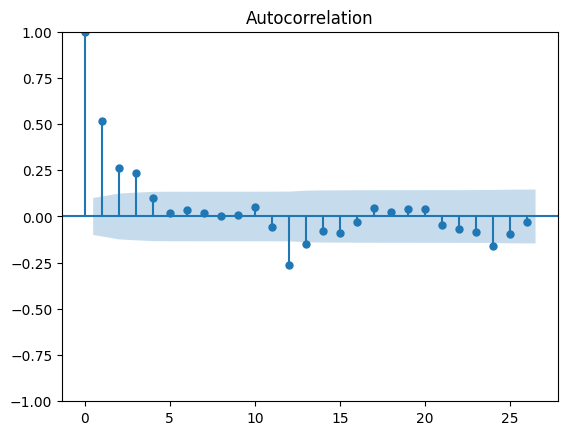

In [66]:
## Auto Correlation analysis
acf = plot_acf(electric['Order_12'].dropna())

## Different q Values Evaluation
 > q=2/3

In [67]:
## Train - Test Splitting
train_df = electric[:315]
test_df = electric[315:]

In [68]:
step_fit = auto_arima(train_df['IPG2211A2N'], seasonal=True, m=12)

In [69]:
print(step_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  315
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -670.152
Date:                              Wed, 03 Jul 2024   AIC                           1352.305
Time:                                      21:20:13   BIC                           1374.587
Sample:                                  01-01-1985   HQIC                          1361.219
                                       - 03-01-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1186      0.069      1.727      0.084      -0.016       0.253
ar.L1          0.92

### Building SARIMAX Model

In [73]:
model = SARIMAX(train_df['IPG2211A2N'], order= step_fit.order, seasonal_order=step_fit.seasonal_order)

D:\Data Engineering Project\ML Project\aiwork\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Data Engineering Project\ML Project\aiwork\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [74]:
fit_model=model.fit(disp= False)

In [75]:
print(fit_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           IPG2211A2N   No. Observations:                  315
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -673.350
Date:                              Wed, 03 Jul 2024   AIC                           1356.700
Time:                                      21:20:45   BIC                           1375.268
Sample:                                  01-01-1985   HQIC                          1364.129
                                       - 03-01-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9981      0.003    345.451      0.000       0.992       1.004
ma.L1         -0.41

In [76]:
test_df.head(10)

,IPG2211A2N,Order_12
DATE,,
2011-04-01,89.3583,3.0583
2011-05-01,90.0698,-0.7666
2011-06-01,102.8204,-1.5334
2011-07-01,114.7068,1.9002
2011-08-01,113.5958,0.6944
2011-09-01,99.4712,-0.6497
2011-10-01,90.3566,1.4315
2011-11-01,93.8095,1.0345
2011-12-01,107.3312,-6.9954


### Predictions using SARIMAX

In [77]:
# Predictions
pred = fit_model.predict(start = test_df.index[0], end = test_df.index[-1])

In [78]:
pred

2011-04-01     90.159342
2011-05-01     92.056603
2011-06-01    102.981224
2011-07-01    110.711947
2011-08-01    111.491753
                 ...    
2017-09-01    104.232216
2017-10-01     96.293288
2017-11-01     98.374755
2017-12-01    115.973669
2018-01-01    122.579014
Freq: MS, Name: predicted_mean, Length: 82, dtype: float64

In [79]:
test_df['SARIMA_Pred'] = pred

C:\Users\ASUS\AppData\Local\Temp\ipykernel_52908\955077632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['SARIMA_Pred'] = pred


In [80]:
test_df

,IPG2211A2N,Order_12,SARIMA_Pred
DATE,,,
2011-04-01,89.3583,3.0583,90.159342
2011-05-01,90.0698,-0.7666,92.056603
2011-06-01,102.8204,-1.5334,102.981224
2011-07-01,114.7068,1.9002,110.711947
2011-08-01,113.5958,0.6944,111.491753
...,...,...,...
2017-09-01,98.6154,-4.1483,104.232216
2017-10-01,93.6137,2.1270,96.293288
2017-11-01,97.3359,4.4459,98.374755


## Plotting value

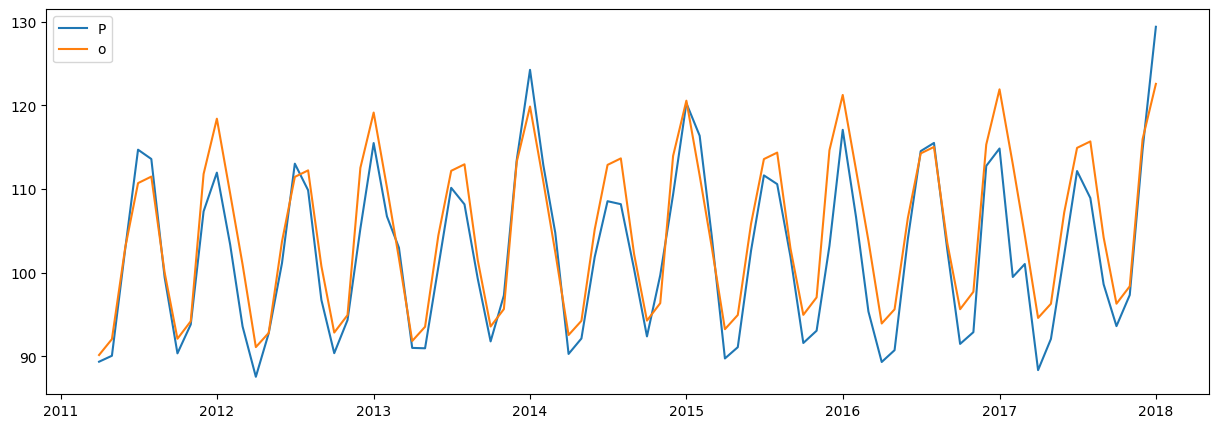

In [87]:
plt.figure(figsize= (15,5))
plt.plot(test_df.index,test_df['IPG2211A2N'], label = 'Actual Values')
plt.plot(test_df.index,test_df['SARIMA_Pred'], label = 'Forecasted Values')
plt.legend("Power Consumption Actual Values vs SARIMA Predicted Values")